## Import Libraries and Data

In [118]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Deep Learning Libraries
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Add, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import F1Score

# File Handling
import joblib




## Preprocessing
In the preprocessing step, we define the categorical and numerical columns that we intend to process further.

- **Target column**: The **obesity category (NObeyesdad)** is the target feature we want to predict in this case (e.g., normal weight, overweight level I, etc.).

- **Categorical features**: We apply **one-hot encoding** including target column (by using <code>to_categorical</code>) instead of label encoding since deep learning models are capable of handling high-dimensional data efficiently.

- **Numerical features**: We apply **standardization** by subtracting the mean and dividing by the standard deviation for each feature. This ensures that no single feature disproportionately influences the model due to scale differences.

Finally, we split the dataset into a **20% test set**, **~10% validation set** and an **~70% training set**, which is a typical ratio used in machine learning.

In [74]:
DATA_PATH = 'data/train.csv'

df = pd.read_csv(DATA_PATH)
df = df.drop('id', axis=1)
print(f'Sample size: {len(df)}, Data shape: {df.shape}')
df.head()


Sample size: 20758, Data shape: (20758, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [105]:
def preprocess_data(df, target_column='NObeyesdad', mode='train', encoder_path=None, label_encoder_path=None):
    categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
    numerical_columns = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF', 'TUE']
    
    numerical_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ])

    if mode == 'train':
        if target_column in df.columns:
            le = LabelEncoder()
            y = le.fit_transform(df[target_column])
            y = to_categorical(y, num_classes=len(le.classes_))
            X = df.drop(target_column, axis=1)
            print(f'Label Encoded target classes: {le.classes_}')
            # Fit and transform
            X_transformed = preprocessor.fit_transform(X)
            # Save the preprocessor and label encoder
            joblib.dump(preprocessor, encoder_path)
            joblib.dump(le, label_encoder_path)
        else:
            y = None
            X = df
            X_transformed = preprocessor.fit_transform(X)
            joblib.dump(preprocessor, encoder_path)
    else:
        # Load the saved preprocessor and label encoder
        preprocessor = joblib.load(encoder_path)
        le = joblib.load(label_encoder_path)
        y = None if target_column not in df.columns else to_categorical(le.transform(df[target_column]), num_classes=len(le.classes_))
        X = df.drop(target_column, axis=1) if target_column in df.columns else df
        X_transformed = preprocessor.transform(X)

    return (X_transformed, y, le) if target_column in df.columns else (X_transformed)

In [109]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

X_train, y_train, label_encoder = preprocess_data(df_train, target_column='NObeyesdad', mode='train', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
X_test, y_test, _ = preprocess_data(df_test, target_column='NObeyesdad', mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
X_val, y_val, _ = preprocess_data(df_val, target_column='NObeyesdad', mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')

print(f'\nX_train shape before: {df_train.shape} -> after transformation: {X_train.shape}')
print(f'\nX_test shape before: {df_test.shape} -> after transformation: {X_test.shape}')
print(f'\nX_val shape before: {df_val.shape} -> after transformation: {X_val.shape}')

Label Encoded target classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']

X_train shape before: (14530, 17) -> after transformation: (14530, 29)

X_test shape before: (4152, 17) -> after transformation: (4152, 29)

X_val shape before: (2076, 17) -> after transformation: (2076, 29)


In [110]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)

model = Sequential([
    Input(shape=(29,)),
    Dense(128, activation="relu", kernel_initializer=HeUniform()),
    Dropout(0.2),
    Dense(64, activation="relu", kernel_initializer=HeUniform()),
    Dense(7, activation="softmax")
])
model.summary()
model.compile(optimizer=Adam(learning_rate=lr_schedule), 
              loss="categorical_crossentropy", 
              metrics=[F1Score(average='weighted', name='f1_score'),
                       "accuracy"])


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,551 (49.03 KB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
callback = EarlyStopping(monitor='val_f1_score', patience=5, min_delta=1e-3, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=32,
          callbacks=[callback])
model.save('../../models/obesity_model.keras')

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2899 - f1_score: 0.2721 - loss: 1.8725 - val_accuracy: 0.6055 - val_f1_score: 0.5723 - val_loss: 1.1589
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5829 - f1_score: 0.5628 - loss: 1.1580 - val_accuracy: 0.6671 - val_f1_score: 0.6494 - val_loss: 0.8907
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6425 - f1_score: 0.6291 - loss: 0.9490 - val_accuracy: 0.7119 - val_f1_score: 0.6993 - val_loss: 0.7642
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6795 - f1_score: 0.6711 - loss: 0.8223 - val_accuracy: 0.7452 - val_f1_score: 0.7348 - val_loss: 0.6826
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7157 - f1_score: 0.7086 - loss: 0.7369 - val_accuracy: 0.7775 - val_f1_score: 0.7709 - val_loss: 0.6181
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7326 - f1_score: 0.7272 - loss: 0.6881 - val_accuracy: 0.8006 - val_f1_sco

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.8638 - f1_score: 0.8642 - loss: 0.3843
Test Loss: 0.3879
Test F1 Score: 0.8665
Test Accuracy: 86.68%
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
['Obesity_Type_III' 'Overweight_Level_I' 'Obesity_Type_I' ...
 'Obesity_Type_I' 'Overweight_Level_I' 'Overweight_Level_II']


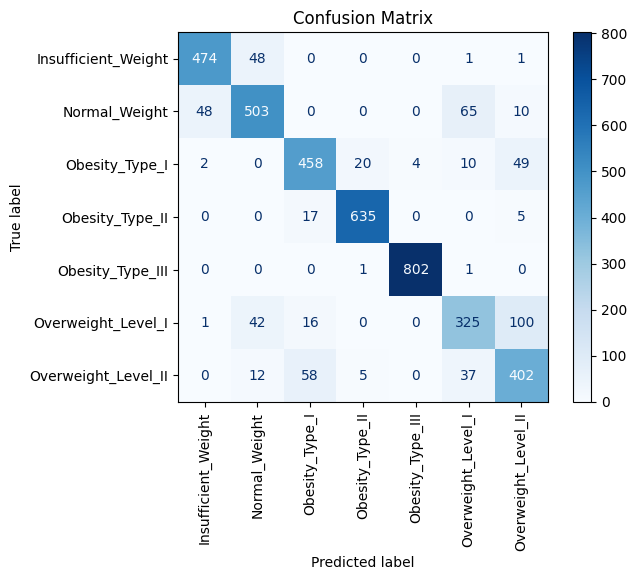

In [97]:
loss, f1_score, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize the predictions
y_pred_temp = model.predict(X_test)
y_pred_temp = np.argmax(y_pred_temp, axis=1)
y_pred_temp = label_encoder.inverse_transform(y_pred_temp)

y_test_temp = np.argmax(y_test, axis=1)
y_test_temp = label_encoder.inverse_transform(y_test_temp)
print(y_test_temp)

cm = confusion_matrix(y_test_temp, y_pred_temp)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict(input):
    model = load_model('../../models/obesity_model.keras')

    # Check model, encoder, and label encoder existence
    PREPROCESSOR_PATH = 'obesity_preprocessor.pkl'
    LABEL_ENCODER_PATH = 'obesity_label_encoder.pkl'
    if not model:
        raise Exception("Model not found.")
    if not joblib.load(PREPROCESSOR_PATH):
        raise Exception("Encoder not found.")
    if not joblib.load(LABEL_ENCODER_PATH):
        raise Exception("Label encoder not found.")
    
    input = pd.DataFrame([input])
    input_transformed = preprocess_data(input, target_column=None, mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
    y_pred_temp = model.predict(input_transformed)
    y_pred_temp = np.argmax(y_pred_temp, axis=1)
    y_pred_temp = label_encoder.inverse_transform(y_pred_temp)
    return y_pred_temp[0]

# Example usage
input = {
    "Gender": "Male",
    "Age": 24.443011,
    "Height": 1.699998,
    "Weight": 81.66995,
    "family_history_with_overweight": "yes",
    "FAVC": "yes",
    "CAEC": "Sometimes",
    "NCP": 2.983297,
    "CH2O": 2.763573,
    "SMOKE": "no",
    "SCC": "no",
    "FAF": 0,
    "TUE": 0.976473,
    "CALC": "Sometimes",
    "MTRANS": "Public_Transportation"
}
print(predict(input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Overweight_Level_II
